In [1]:
# loadings and defaults
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage

import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker

%config InlineBackend.figure_format='png'



In [2]:
# my functions



def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})
    print('done renaming')
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])
    print('made grid object')

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta.mean(dim="ocean_time") + ds.zice + (ds.zeta.mean(dim="ocean_time") + ds.zice + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta.mean(dim="ocean_time") + ds.zice + ds.h) + ds.zeta.mean(dim="ocean_time") + ds.zice

    print('done making vertical coords')

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')
    print('done interpolation of depths')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('done interpolation of x,y')

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy
    print('made metrics')

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    print('assigned metrics')
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [83]:
norm = xr.open_dataset('/Users/dave/Documents/dave/Projects/totten_sgfw/tisom017_sgfw/data/proc/tisom_his_0021_trimmed.nc')
gridFile=xr.open_dataset('/Users/dave/Documents/dave/Projects/totten_sgfw/tisom017_sgfw/data/raw/tisom008_canal_grd.nc')
mask_zice = (norm.zice<0)
mask_zice_nan = mask_zice.where(mask_zice!=0.0,np.nan)

In [88]:
norm = processROMSGrid(norm)

done renaming
made grid object
done making vertical coords
done interpolation of depths
done interpolation of x,y
made metrics
assigned metrics


In [89]:
norm

<xarray.Dataset>
Dimensions:        (boundary: 4, eta_rho: 260, eta_v: 259, ocean_time: 365, s_rho: 31, s_w: 32, tracer: 3, xi_rho: 381, xi_u: 380)
Coordinates: (12/13)
    lat_psi        (eta_v, xi_u) float64 -67.58 -67.58 -67.58 ... -60.03 -60.03
    lat_rho        (eta_rho, xi_rho) float64 -67.59 -67.59 ... -60.02 -60.02
    lat_u          (eta_rho, xi_u) float64 -67.59 -67.59 ... -60.02 -60.02
    lat_v          (eta_v, xi_rho) float64 -67.58 -67.58 ... -60.03 -60.03
    lon_psi        (eta_v, xi_u) float64 104.6 104.7 104.8 ... 129.8 129.8 129.9
    lon_rho        (eta_rho, xi_rho) float64 104.6 104.7 104.7 ... 129.9 129.9
    ...             ...
    lon_v          (eta_v, xi_rho) float64 104.6 104.7 104.7 ... 129.9 129.9
  * ocean_time     (ocean_time) object 0020-12-29 00:00:00 ... 0021-12-28 00:...
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    z_w            (s_w, eta_rho, xi_rho) float64 0.0 0.0 ... -0.03696 -0.03696
    z_rho          (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -0.8846 -0.8846
Dimensions without coordinates: boundary, eta_rho, eta_v, tracer, xi_rho, xi_u
Data variables: (12/94)
    Akt_bak        (tracer) float64 1e-06 1e-06 1e-06
    Akv_bak        float64 0.0001
    Cs_r           (s_rho) float64 -0.9588 -0.8777 ... -0.001083 -0.00012
    Cs_w           (s_w) float64 -1.0 -0.918 -0.8379 ... -0.0004805 0.0
    FSobc_in       (boundary) float64 0.0 0.0 0.0 0.0
    FSobc_out      (boundary) float64 0.0 0.0 0.0 0.0
    ...             ...
    dz_w           (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.8846 0.8846
    dz_u           (s_rho, eta_rho, xi_u) float64 0.0 0.0 0.0 ... 2.75 2.75 2.75
    dz_w_u         (s_w, eta_rho, xi_u) float64 0.0 0.0 0.0 ... 0.8834 0.8846
    dz_v           (s_rho, eta_v, xi_rho) float64 0.0 0.0 0.0 ... 2.75 2.75 2.75
    dz_w_v         (s_w, eta_v, xi_rho) float64 0.0 0.0 0.0 ... 0.8846 0.8846
    dA             (eta_rho, xi_rho) float64 8.218e+06 8.218e+06 ... 1.5e+07
Attributes: (12/28)
    file:              tisom_his_0021.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             Totten Ice Shelf/Ocean Application
    rst_file:          tisom_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model precise -ip -O3 -free -free
    tiling:            016x018
    history:           Mon Nov  1 10:51:43 2021: ncks -O -x -v sustr,svstr,ss...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       TOTTEN_SGFW, ADD_FSOBC, ANA_BPFLUX, ANA_BSFLUX, ANA_BT...
    NCO:               netCDF Operators version 4.9.2 (Homepage = http://nco....

<ipython-input-202-ed8a8da6731b>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(gridFile.x_rho,gridFile.y_rho,gridFile.h+gridFile.zice,vmin=0,vmax=100)


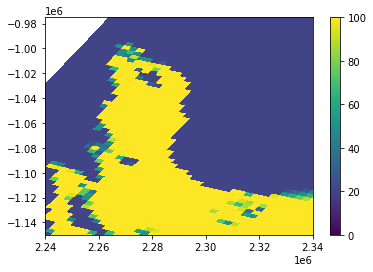

In [202]:
plt.pcolormesh(gridFile.x_rho,gridFile.y_rho,gridFile.h+gridFile.zice,vmin=0,vmax=100)
plt.xlim([2.240e6,2.340e6])
plt.ylim([-1.150e6,-.975e6])
plt.colorbar()

In [184]:
norm['x_rho']=gridFile.x_rho
norm['y_rho']=gridFile.y_rho
norm = norm.set_coords(['x_rho','y_rho'])
norm.ocean_time.values

array([cftime.DatetimeJulian(20, 12, 29, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(20, 12, 30, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(20, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 2, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 3, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 4, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 5, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 6, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 7, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 8, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 9, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 10, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(21, 1, 11, 0, 0

<ipython-input-203-2436b490796d>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Y,Z,temp_500m.squeeze(),vmin=-.2,vmax=.2)


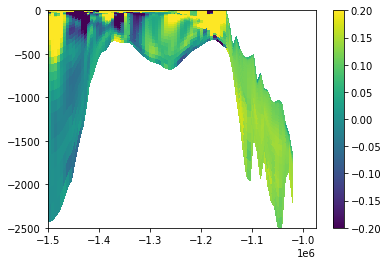

In [203]:
grid = makeROMSGridObject(norm)
depth_snapshot = norm['x_rho']
temp_500m = grid.transform(norm.temp.isel(ocean_time=0)-norm.temp.isel(ocean_time=360), 'X', np.array([2.285e6]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m#.isel(x_rho=0).plot(x='eta_rho',y='z_rho')


zz = grid.transform(norm.z_rho, 'X', np.array([2.285e6]),
                                target_data=depth_snapshot,
                                method='linear')

yy = grid.transform(norm.y_rho, 'X', np.array([2.285e6]),
                                target_data=depth_snapshot,
                                method='linear')



Z = zz.squeeze().fillna(20)

Y = yy.squeeze().fillna(-3e6)

plt.pcolormesh(Y,Z,temp_500m.squeeze(),vmin=-.2,vmax=.2)
plt.xlim([-1.50e6,-.975e6])
plt.ylim([-2500,0])
plt.colorbar()

<ipython-input-199-3e5e99f48f2a>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Z,temp_500m.squeeze(),vmin=-2,vmax=0)


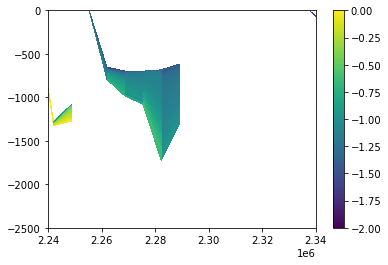

In [199]:
grid = makeROMSGridObject(norm)
depth_snapshot = norm['y_rho']
temp_500m = grid.transform(norm.temp.isel(ocean_time=360), 'Y', np.array([-1.1e6]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m#.isel(x_rho=0).plot(x='eta_rho',y='z_rho')


zz = grid.transform(norm.z_rho, 'Y', np.array([-1.1e6]),
                                target_data=depth_snapshot,
                                method='linear')

xx = grid.transform(norm.x_rho, 'Y', np.array([-1.1e6]),
                                target_data=depth_snapshot,
                                method='linear')



Z = zz.squeeze().fillna(20)

X = xx.squeeze().fillna(-3e6)

plt.pcolormesh(X,Z,temp_500m.squeeze(),vmin=-2,vmax=0)
plt.xlim([2.240e6,2.340e6])
plt.ylim([-2500,0])
plt.colorbar()

<ipython-input-28-deed016138a9>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(norm.x_rho,norm.y_rho,norm.temp.isel(ocean_time=0,s_rho=-1))


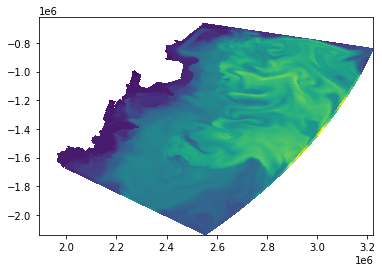

In [28]:
plt.pcolormesh(norm.x_rho,norm.y_rho,norm.temp.isel(ocean_time=0,s_rho=-1))

In [16]:
from metpy.interpolate import cross_section

# Define start and end points:
data = norm.metpy.parse_cf().squeeze()
start = (114.5, -67.25)
end = (116.5,-66.75)
# cross = cross_section(data, start, end).set_coords(('lat', 'lon'))

data

<xarray.Dataset>
Dimensions:        (boundary: 4, eta_psi: 259, eta_rho: 260, eta_u: 260, eta_v: 259, ocean_time: 365, s_rho: 31, s_w: 32, tracer: 3, xi_psi: 380, xi_rho: 381, xi_u: 380, xi_v: 381)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    lat_rho        (eta_rho, xi_rho) float64 -67.59 -67.59 ... -60.02 -60.02
    lon_rho        (eta_rho, xi_rho) float64 104.6 104.7 104.7 ... 129.9 129.9
  * ocean_time     (ocean_time) object 0020-12-29 00:00:00 ... 0021-12-28 00:...
    lat_psi        (eta_psi, xi_psi) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lon_u          (eta_u, xi_u) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables: (12/71)
    Akt_bak        (tracer) float64 ...
    Akv_bak        float64 ...
    Cs_r           (s_rho) float64 ...
    Cs_w           (s_w) float64 ...
    FSobc_in       (boundary) float64 ...
    FSobc_out      (boundary) float64 ...
    ...             ...
    temp           (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    theta_b        float64 ...
    theta_s        float64 ...
    xl             float64 ...
    zeta           (ocean_time, eta_rho, xi_rho) float32 ...
    zice           (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/28)
    file:              tisom_his_0021.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             Totten Ice Shelf/Ocean Application
    rst_file:          tisom_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model precise -ip -O3 -free -free
    tiling:            016x018
    history:           Mon Nov  1 10:51:43 2021: ncks -O -x -v sustr,svstr,ss...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       TOTTEN_SGFW, ADD_FSOBC, ANA_BPFLUX, ANA_BSFLUX, ANA_BT...
    NCO:               netCDF Operators version 4.9.2 (Homepage = http://nco....

(10.0, 30.0)

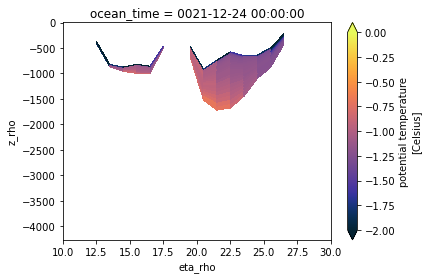

In [ ]:
norm.temp.isel(ocean_time=360,xi_rho=165).plot(y='z_rho',vmin=-2,vmax=0, cmap='cmo.thermal')
plt.xlim([10,30])


(140.0, 170.0)

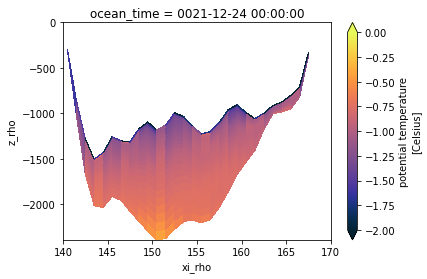

In [ ]:
norm.temp.isel(ocean_time=360,eta_rho=15).plot(y='z_rho',vmin=-2,vmax=0, cmap='cmo.thermal')
plt.xlim([140,170])

(0.0, 50.0)

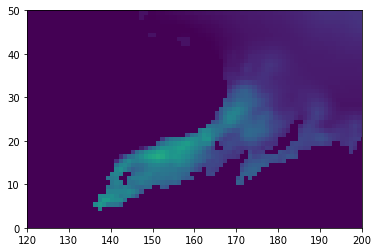

In [ ]:
plt.pcolormesh(gridFile.h)
plt.xlim([120,200])
plt.ylim([0,50])

<ipython-input-141-7581a8219522>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,gridFile.h)


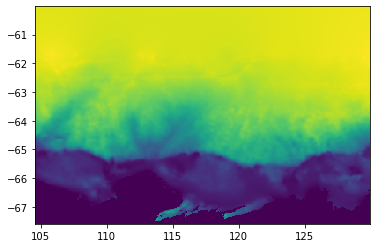

In [ ]:
plt.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,gridFile.h)

<Figure size 432x288 with 0 Axes>

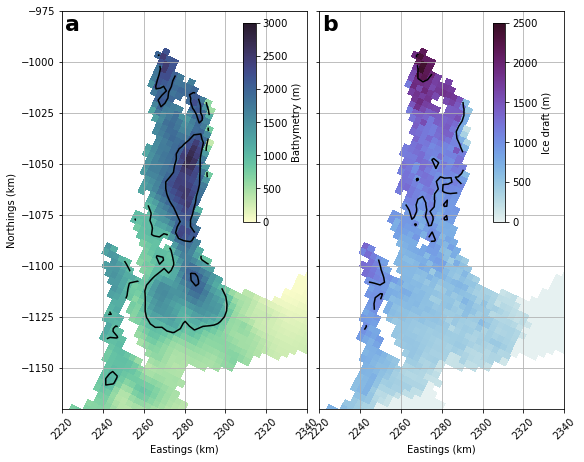

In [ ]:

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,8.5])
ax = None

# add plots

ax1 = fig.add_subplot(gs[0,0])
im = ax1.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.h.where(norm.zice!=0,np.nan),cmap='cmo.deep',vmin=0,vmax=3000,shading='nearest')
co = ax1.contour(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.h.where(norm.zice!=0,np.nan),levels=[0,1000,2000,3000],colors='k',vmin=0,vmax=3000)
ax1.set_ylabel('Northings (km)')
ax1.set_xlabel('Eastings (km)')
ax1.grid()
ax1.text(0.01, 0.99, 'a', transform=ax1.transAxes,fontsize=22, fontweight='bold', va='top')
plt.axis('scaled')
ax1.set_ylim([-1.170e3,-.9750e3])
ax1.set_xlim([2.220e3,2.340e3])
plt.xticks(rotation=45)
cax = inset_axes(ax1,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.74,.47, 1, 1),
                 bbox_transform=ax1.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('Bathymetry (m)')

ax2 = fig.add_subplot(gs[0,1])
im = ax2.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.zice.where(norm.zice!=0,np.nan)*-1,cmap='cmo.dense',vmin=0,vmax=2500,shading='nearest')
co = ax2.contour(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.zice.where(norm.zice!=0,np.nan)*-1,levels=[0,1000,2000],colors='k',vmin=0,vmax=3000)

ax2.set_xlabel('Eastings (km)')
ax2.grid()
ax2.set_yticklabels('')
ax2.text(0.01, 0.99, 'b', transform=ax2.transAxes,fontsize=22, fontweight='bold', va='top')
plt.axis('scaled')
ax2.set_ylim([-1.170e3,-.9750e3])
ax2.set_xlim([2.220e3,2.340e3])
plt.xticks(rotation=45)
cax = inset_axes(ax2,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.71,.47, 1, 1),
                 bbox_transform=ax2.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('Ice draft (m)')

plt.savefig('../outputs/figure_bathy_draft.png',dpi=300)
